# Libraries import

In [ ]:
# %pip install "datasets" "scikit-learn" "torchmetrics>=0.7" "scipy" "pytorch-lightning==1.8.6" "transformers" "torchtext>=0.9" "setuptools==59.5.0" "ipython[notebook]" "torch==1.13" "seaborn"

In [ ]:
# %pip install 'torch==1.13' torchvision torchaudio

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%cd LiU/732A81 - Text Mining project
%pwd

# Import all libraries
import pandas as pd
import numpy as np
import re

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

/workspace/LiU/732A81 - Text Mining project


# Load data

In [2]:
from datasets import load_dataset
dataset = load_dataset('eurlex')
#eurovoc_concepts_df = pd.read_json('./data/datasets/EURLEX57K/eurovoc_concepts.jsonl', lines=True)

train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
val = pd.DataFrame(dataset['validation'])
#cumulative = pd.concat([train, test, val])

No config specified, defaulting to: eurlex/eurlex57k
Found cached dataset eurlex (/root/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Load the data from disk
import pickle
with open('./data/preprocessed_title/x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)
with open('./data/preprocessed_title/x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)
with open('./data/preprocessed_title/x_val.pkl', 'rb') as f:
    x_val = pickle.load(f)
with open('./data/preprocessed_title/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('./data/preprocessed_title/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
with open('./data/preprocessed_title/y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('./data/preprocessed_title/y.pkl', 'rb') as f:
    y = pickle.load(f)
with open('./data/preprocessed_title/eurovoc_concepts_df.pkl', 'rb') as f:
    eurovoc_concepts_df = pickle.load(f)
with open('./data/preprocessed_title/cumulative.pkl', 'rb') as f:
    cumulative = pickle.load(f)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(cumulative['eurovoc_concepts_limited'])

# Pre-process the data

Commented out for safety since it takes a long time to run. It's advised to load from disk.

In [4]:
# import spacy
# nlp = spacy.load('en_core_web_lg', exclude=['parser', 'ner'])

# def preprocess(text):
#     # TODO: Replace the next line with your own code.
#     doc = nlp(text)
#     data = [(token.lemma_) for token in doc if token.is_alpha and not token.is_stop and token.lemma_.isalpha()]
#     data = pd.DataFrame(data, columns=['lemma'])
#     return list(data.lemma)

In [5]:
# train.head()

# train['preprocessed'] = train['title'].apply(preprocess)
# test['preprocessed'] = test['title'].apply(preprocess)
# val['preprocessed'] = val['title'].apply(preprocess)
# cumulative = pd.concat([train, test, val])

In [6]:
# train.head()

In [7]:
# labels_count = cumulative.explode('eurovoc_concepts').groupby('eurovoc_concepts').count().reset_index()
# labels_count = labels_count[['eurovoc_concepts', 'text']]
# labels_count.columns = ['eurovoc_concepts', 'count']
# labels_count.head(10)

In [8]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("whitegrid")

# # plot histogram of the number of documents per class
# plt.hist(labels_count['count'], bins=100, range=(0, 600))
# plt.xlabel('Number of documents')
# plt.ylabel('Number of classes')
# plt.bar(500, labels_count[labels_count['count'] >= 500].count(), color='black', width=5)
# plt.show();

In [9]:
# # Number of classes with less than 10 documents
# print(f'Number of classes with less than 10 documents: {labels_count[labels_count["count"] < 10].count().values[0]}')

# # Number of classes with less than 50 documents
# print(f'Number of classes with less than 50 documents: {labels_count[labels_count["count"] < 50].count().values[0]}')


Keep only labels that have more than 10 documents

In [10]:
# labels_count = labels_count[labels_count['count'] >= 10].reset_index(drop=True)

# eurovoc_concepts_df = eurovoc_concepts_df[eurovoc_concepts_df['id'].isin(labels_count['eurovoc_concepts'])].sort_values(by='id').reset_index(drop=True)

In [11]:
# # Remove classes with less than 10 documents from the dataset and keep the ones left

# train['eurovoc_concepts_limited'] = train['eurovoc_concepts'].apply(lambda x: [i for i in x if i in labels_count['eurovoc_concepts'].values])
# train = train[train['eurovoc_concepts_limited'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
# test['eurovoc_concepts_limited'] = test['eurovoc_concepts'].apply(lambda x: [i for i in x if i in labels_count['eurovoc_concepts'].values])
# test = test[test['eurovoc_concepts_limited'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
# val['eurovoc_concepts_limited'] = val['eurovoc_concepts'].apply(lambda x: [i for i in x if i in labels_count['eurovoc_concepts'].values])
# val = val[val['eurovoc_concepts_limited'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
# cumulative = pd.concat([train, test, val], keys=['train', 'test', 'val'])

In [12]:
# cumulative.head()

Binarize the labels

In [13]:
# from sklearn.preprocessing import MultiLabelBinarizer

# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(cumulative['eurovoc_concepts_limited'])
# y.shape

In [14]:
# x_train = cumulative.loc['train', 'preprocessed'].reset_index(drop=True)
# x_test = cumulative.loc['test', 'preprocessed'].reset_index(drop=True)
# x_val = cumulative.loc['val', 'preprocessed'].reset_index(drop=True)

# y_train = y[:len(x_train)].copy()
# y_test = y[len(x_train):len(x_train)+len(x_test)].copy()
# y_val = y[len(x_train)+len(x_test):].copy()


In [15]:
# # Save the data to disk for later use
# import pickle
# with open('./data/preprocessed_title/x_train.pkl', 'wb') as f:
#     pickle.dump(x_train, f)
# with open('./data/preprocessed_title/x_test.pkl', 'wb') as f:
#     pickle.dump(x_test, f)
# with open('./data/preprocessed_title/x_val.pkl', 'wb') as f:
#     pickle.dump(x_val, f)
# with open('./data/preprocessed_title/y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('./data/preprocessed_title/y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)
# with open('./data/preprocessed_title/y_val.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# with open('./data/preprocessed_title/y.pkl', 'wb') as f:
#     pickle.dump(y, f)
# with open('./data/preprocessed_title/eurovoc_concepts_df.pkl', 'wb') as f:
#     pickle.dump(eurovoc_concepts_df, f)
# with open('./data/preprocessed_title/cumulative.pkl', 'wb') as f:
#     pickle.dump(cumulative, f)




# Dataset and dataloader

In [4]:
class QTagDataset(Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }

In [5]:
class QTagDataModule(pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, **kwargs):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=8, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16, num_workers=8, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16, num_workers=8, persistent_workers=True)

In [6]:
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "nlpaueb/legal-bert-base-uncased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [7]:
max_word_cnt = 512
quest_cnt = 0

# For every sentence...
for question in cumulative['preprocessed']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(question, add_special_tokens=True)

    # Update the maximum sentence length.
    if len(input_ids) > max_word_cnt:
        quest_cnt +=1

print(f'# Question having word count > {max_word_cnt}: is  {quest_cnt} out of {len(cumulative)}')

# Question having word count > 512: is  0 out of 56979


In [9]:
# Initialize the parameters that will be use for training
N_EPOCHS = 300
BATCH_SIZE = 16
MAX_LEN = 300
LR = 2e-05

In [10]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_train,y_train,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

# Model Training

In [11]:
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=10, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

In [12]:
# Instantiate the classifier model
steps_per_epoch = len(x_train)//BATCH_SIZE
model = QTagClassifier(n_classes=y.shape[1], steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    dirpath='legalbert_model_with_titles',
    monitor='val_loss',# monitored quantity
    filename='Legal_titles-{epoch:02d}-{val_loss:.5f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
    save_last=True, # save the last model
    verbose=True
)

# Initialize Pytorch Lightning callback for Early Stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=5,
    verbose=True,
    mode='min'
)

# Model logger
logger = TensorBoardLogger('lightning_logs', name='LegalBert_titles')


In [14]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS ,accelerator='auto', devices=[0], callbacks=[checkpoint_callback, early_stop_callback], enable_progress_bar=True, precision=16, amp_backend="native", logger=logger)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
!nvidia-smi

Sat Mar  4 20:27:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P8    13W / 220W |    300MiB /  8192MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# Train the Classifier Model
trainer.fit(model, QTdata_module)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /workspace/LiU/732A81 - Text Mining project/legalbert_model_with_titles exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 109 M 
1 | classifier | Linear            | 1.6 M 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
111 M     Trainable params
0         Non-trainable params
111 M     Total params
222.116   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [49]:
torch.cuda.empty_cache()

# Evaluate the model performance on the test dataset

In [17]:
# Evaluate the model performance on the test dataset
trainer.test(model,datamodule=QTdata_module, ckpt_path='old_models/legalbert_model_with_titles/Legal_titles-epoch=209-val_loss=0.00542.ckpt')

Restoring states from the checkpoint path at old_models/legalbert_model_with_titles/Legal_titles-epoch=209-val_loss=0.00542.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at old_models/legalbert_model_with_titles/Legal_titles-epoch=209-val_loss=0.00542.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0055004931055009365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0055004931055009365}]

In [ ]:
# Visualize the logs using tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Evaluate Model Performance on Test Set

In [34]:
# Retreive the checkpoint path for best model from disk

# Get the path of the best model
model_path = 'legalbert_model_with_titles/Legal_titles-epoch=209-val_loss=0.00542.ckpt'


In [35]:
len(y_test), len(x_test)

(5995, 5995)

In [36]:
# Size of Test set
print(f'Number of Documents = {len(x_test)}')

Number of Documents = 5995


Setup test dataset for BERT

In [37]:
from torch.utils.data import TensorDataset

# Tokenize all questions in x_test
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  Bert_tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_quest['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_quest['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 64  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)

In [38]:
pred_data[0]

(tensor([ 101,  100, 2397,  100,  100, 1836, 1367,  100,  100,  100,  100,  672,
          399, 1399,  794,  295,  234,  100,  100,  100, 1227,  651, 1314, 1663,
         2895,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [39]:
len(pred_dataloader.dataset)

5995

Prediction on test set

In [40]:
flat_pred_outs = 0
flat_true_labels = 0

In [45]:
# Put model in evaluation mode
model = model.to(device) # moving model to cuda
model.eval()

# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # i+=1
        # #Store predictions and true labels
        # print(i)
        # print(outputs)
        # print(logits)
        # print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)

QTagClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [72]:
(pred_outs[0]).shape

print(pred_outs.shape)

(64, 2049)

AttributeError: 'list' object has no attribute 'shape'

In [68]:
sum(true_labels[0][0])

15

In [52]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [53]:
flat_pred_outs.shape , flat_true_labels.shape

((5995, 2049), (5995, 2049))

In [93]:
flat_pred_outs

array([[3.46584857e-04, 2.67996197e-03, 1.50957567e-04, ...,
        4.48089151e-04, 4.86372955e-05, 7.03531550e-05],
       [5.86799933e-06, 4.46607373e-06, 1.02724434e-05, ...,
        3.29661179e-06, 1.31615679e-05, 2.26070597e-06],
       [1.43608358e-05, 1.10853416e-05, 2.47549656e-06, ...,
        1.89651128e-05, 1.19576915e-04, 2.59296703e-05],
       ...,
       [7.43685523e-05, 4.43305908e-05, 1.84581877e-04, ...,
        6.67782342e-06, 1.21429628e-04, 3.13362107e-04],
       [1.05516265e-04, 4.06543637e-04, 1.51763918e-04, ...,
        1.35363734e-04, 9.31357499e-06, 2.02546489e-05],
       [4.06443942e-05, 3.71630420e-03, 3.67778603e-06, ...,
        5.00009482e-05, 1.46614702e-05, 1.01522928e-05]], dtype=float32)

In [77]:
flat_pred_outs[1].max()
flat_true_labels[1].max()


0.99700254

1

# Predictions of Tags in Test set
The predictions are in terms of logits (probabilities for each of the 16 tags). Hence we need to have a threshold value to convert these probabilities to 0 or 1.

Let's specify a set of candidate threshold values. We will select the threshold value that performs the best for the test set.

In [81]:
#define candidate threshold values
threshold  = 0.5
threshold

0.5

Let's define a function that takes a threshold value and uses it to convert probabilities into 1 or 0.

In [55]:
true_labels

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [56]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred

In [83]:
from sklearn import metrics
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = flat_true_labels.ravel() 

# for thresh in threshold:
    
#classes for each threshold
pred_bin_label = classify(flat_pred_outs,thresh) 

#convert to 1D array
y_pred = np.array(pred_bin_label).ravel()

scores.append(metrics.f1_score(y_true,y_pred))

In [84]:
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')

TypeError: 'float' object is not subscriptable

In [85]:
y_true

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

# Performance Score Evaluation

In [88]:
#predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,0.5)
y_pred = np.array(y_pred_labels).ravel() # Flatten

In [89]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00  12254176
           1       0.79      0.54      0.64     29579

    accuracy                           1.00  12283755
   macro avg       0.89      0.77      0.82  12283755
weighted avg       1.00      1.00      1.00  12283755



Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'F1 score')

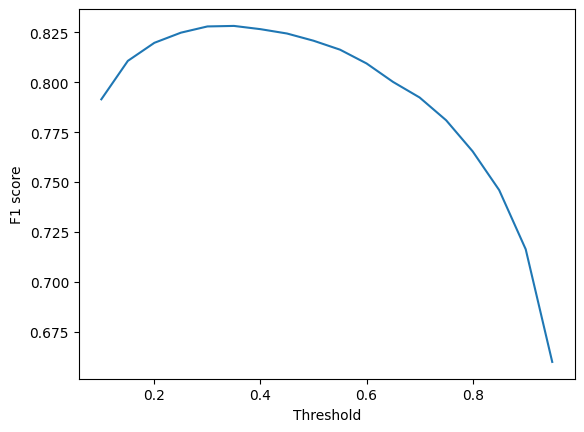

In [95]:
thresholds = np.arange(0.1, 1, 0.05)
f1_scores = []
y_true = flat_true_labels.ravel() 
for threshold in thresholds:
    y_pred_labels = classify(flat_pred_outs, threshold)
    y_pred = np.array(y_pred_labels).ravel() # Flatten
    
    f1_scores.append(metrics.classification_report(y_true, y_pred, output_dict=True)['macro avg']['f1-score'])

# plot the F1 score for different thresholds
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.show()

In [90]:
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)

df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

In [92]:
df.sample(10)

,Body,Actual Tags,Predicted Tags
3374,"[Commission, Regulation, EC, establish, standa...","(1118, 1605, 2635, 693)","(1118, 1605, 2511, 2635, 693)"
4282,"[Commission, Regulation, EC, fix, export, refu...","(3568, 4315, 4316)","(3568, 4315, 4316)"
3522,"[EC, Commission, Decision, January, extension,...","(1445, 1821, 4821, 5034, 5334, 893)","(4821, 5034, 893)"
3651,"[Commission, Regulation, EU, November, amend, ...","(1445, 1598, 1937, 2211, 2891, 5252, 616, 6307)","(1445, 192, 1937, 5034)"
3644,"[Commission, implement, Decision, finance, wor...","(1000, 5158, 5769, 6569)","(1005, 191, 5462, 6569)"
351,"[Commission, Regulation, EC, February, concern...","(4163, 5451, 6052, 6322)","(1277, 1590, 6052, 6322)"
4224,"[Euratom, EEC, Commission, Decision, March, au...","(2602, 3246, 336, 5868)","(4585, 5581)"
3940,"[EEC, Commission, Decision, June, amend, Counc...","(1374, 1642, 192, 3191, 4689, 5063)","(1374, 192, 4689)"
921,"[Commission, Regulation, EC, December, amend, ...","(1309, 2957, 3732, 4078)","(1309, 2300, 2871, 3732, 4078, 4080)"
2077,"[EC, Commission, Decision, October, draw, prov...","(1598, 1644, 2300, 2738, 3191)","(1309, 192, 2300, 2738)"
